# Clustering: Below-Phoneme

Import libraries and helpers

In [1]:
import os, sys

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

from dataset.loading import DataLoader
from lib.plotting.plot_1 import *
from lib.esn import ESN
from lib.clustering.clustering_metrics import *
from experiments.exp2_below_phoneme_clustering.kmeans.method import *
from experiments.exp2_below_phoneme_clustering.kmeans.kmeans import KMeans
from experiments.helpers.experiment_helpers import *

import numpy as np
import random
import warnings
import pandas as pd

np.random.seed(0)
random.seed(0)
warnings.filterwarnings("ignore")

#### Data
Collect the training dataset.
It is restricted to 50 speakers of equal male-female distributions and only contains "SX" (phonetically diverse) sentences. The data are pre-processed into 10 steps long 14-mffc signals with 39 phoneme labels.

In [2]:
save = True

data_path = '../../../'
cache_dir = '../../cache/'
dl = DataLoader(data_path, cache_dir)

dr = []
descriptions = dl.read_descriptions("Train")
speakers = descriptions.speaker_id.unique()
df = pd.DataFrame({"speaker_id":speakers})
df['gender'] = df.speaker_id.str[0]
speakers = df.groupby("gender").sample(50, replace=False).speaker_id.values
sentence = "SX"

XorZ = "X"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10
const_params = {
    "n_mels":n_mels,
    "XorZ":XorZ,
    "N":100
}

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+path_option
if len(speakers):
    path_option = str(len(speakers))+path_option
if sentence:
    path_option = sentence+path_option

features,labels,oversamplings = dl.collectFeaturesInSegments(
    n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,
    sentence=sentence,subsamples=subsamples,path_option=path_option)

-from output
---- success


Regroup data and label arrays into a phoneme-keyed dictionary. Then, select only a subset of the phonemes and randomly sample them down to an equal number samples per phoneme.

In [3]:
from dataset.data_processing import *

#selected_labels = None
#selected_labels = ["aa", "b", "s", "iy", "f", "p"]
selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh", "er", "ey", "ix", "aw", "axr", "l", "oy", "r", "y"]

minn = 15 #np.min([len(x) for x in list(group_by_labels(features, labels).values())])
print(minn)

phonemes, features, labels = filter_data(features, labels, selected_labels=selected_labels, limit=minn)
group = group_by_labels(features, labels)
n_samples = len(features)
n_classes = len(phonemes)
        
print(f"{str(n_classes)} phonemes: {phonemes}")

15
Filtered to 105 samples of shape (10, 14)
7 phonemes: ['ih', 'ae', 'ah', 'iy', 'aa', 'eh', 'uh']


#### Experiments pre-steps
Initialize the ESN with the parameters found in experiment 1.

In [4]:
XorZ = "X"

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 100,
    "W_in_scale": 1.1,
    "b_scale": .6,
    "spectral_radius": 2.57,
    "weights": .1
}

esn = ESN(esn_params)

esn_states = [ esn.run(feature.T, XorZ=XorZ) for feature in features ]

Compute a conceptor for each sample.
Currently, these are used for clustering only in the condition that uses conceptor similarity as the distance function.

In [5]:
save = False
aperture = "auto"
normalize = True

Cs = compute_Cs(signals=features, esn=esn, aperture=aperture, normalize=normalize, XorZ=XorZ, cache=save, file_identifier=path_option)
target_sum = np.mean([sum_of_singular_vals(C) for C in Cs])

- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  22.552780954498385
normalizing
Target:  7.883856686915489
std 0.23706148523548326


#### Clustering

##### Single run
An example run with the similarity-based condition and random initialization.

In [6]:
#method = Method.SIMS
#method = Method.CENTROIDS
method = Method.OG_SIGNALS
#method = Method.PRED
#method = Method.PRED_CENTROIDS

km = KMeans(method, Cs=Cs, signals=features, esn_states=esn_states, XorZ=XorZ, target_sum=target_sum)

centroids, clusters, ds_hist, cluster_hist = km.k_means(nb_clusters=6, max_epochs=100, init_clusters="random", save=False, debug=True)

Running KMeans: 'random' initialization | Method.OG_SIGNALS method | 6 clusters.
Epoch 0 # centroids: 6
Epoch 1 # centroids: 6
Epoch 2 # centroids: 6
Epoch 3 # centroids: 6
Epoch 4 # centroids: 6
Epoch 5 # centroids: 6
Epoch 6 # centroids: 6
Epoch 7 # centroids: 6
Epoch 8 # centroids: 6
Epoch 9 # centroids: 6
Epoch 10 # centroids: 6
Epoch 11 # centroids: 6
Converged


Evaluation of the single run:

1. The Normalized Mutual Information (NMI) for evaluating how well clusters matched the original classes on a range between 0 (no overlaps) and 1 (perfect match)
2. The (Simplified) Silhouette Coefficient (SC) for evaluating the cohesiveness of the clusters, i.e., the mean difference between intra-cluster and inter-cluster distances, on a range between -1 and 1, where a high value corresponds to highly cohesive clusters.

Caution for interpretation: The SC is dependent on the distance function for its computation potentially prioritizing some distance functions.

Correct NMI:  1.0
Truth silhouette:  0.010715689
Lengths correct:  [15, 15, 15, 15, 15, 15, 15]
Kmeans NMI:  0.2252776466631419
Kmeans silhouette:  0.2260645
Lengths kmeans:  [10, 18, 21, 18, 15, 23]
Baseline NMI:  0.08916672949277367
Baseline silhouette:  -0.0318876046171811
Lengths baseline:  [17, 17, 17, 17, 17, 17]


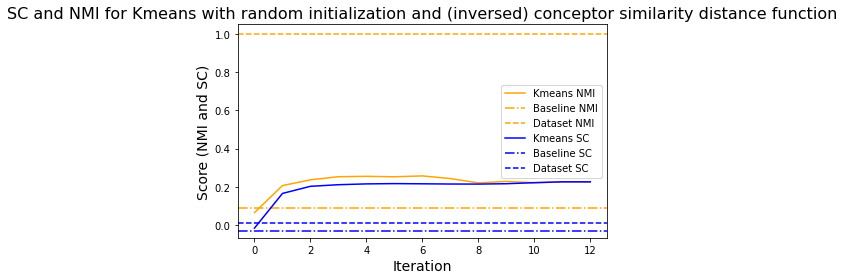

In [33]:
# Converting the clusters to an index-based representation
assignment_hist = [ km.cluster_to_assignment_repr(cluster) for cluster in cluster_hist ]
assignments_kmeans = assignment_hist[-1]

# Collecting the "ground truth" clusters
correct_assignments = [ [] for _ in range(n_classes) ]
idx = 0
for i, phoneme in enumerate(group.keys()):
    for _ in group[phoneme]:
        correct_assignments[i].append(idx)
        idx += 1
correct_clusters = km.assignment_to_cluster_repr(correct_assignments)

nmi_truth = NMI(correct_assignments, correct_assignments)
sil_truth = Silhouette(km).simpl_silh(correct_clusters)
print("Correct NMI: ", nmi_truth)
print("Truth silhouette: ", sil_truth)
print("Lengths correct: ", [len(x) for x in correct_assignments])

nmi_kmeans = NMI(assignments_kmeans, correct_assignments)
sil_kmeans = Silhouette(km).simpl_silh(clusters)
print("Kmeans NMI: ", nmi_kmeans)
print("Kmeans silhouette: ", sil_kmeans)
print("Lengths kmeans: ", [len(x) for x in assignments_kmeans])

clusters_random = km.assign_to_clusters(len(clusters))
assignments_random = km.cluster_to_assignment_repr(clusters_random)
nmi_baseline = NMI(assignments_random, correct_assignments)
sil_baseline = Silhouette(km).simpl_silh(clusters_random)
print("Baseline NMI: ", nmi_baseline)
print("Baseline silhouette: ", sil_baseline)
print("Lengths baseline: ", [len(x) for x in assignments_random])

NMI_list = NMIs_from_list(assignment_hist, correct_assignments)
silh_list = Silhouette(km).simpl_silh_from_list(cluster_hist)

def plot_progress(NMI_list, silh_list, title=''):
    plt.figure()
    plt.plot(NMI_list, color="orange", label="Kmeans NMI")
    plt.axhline(y=nmi_baseline, color='orange', linestyle='dashdot', label="Baseline NMI")
    plt.axhline(y=nmi_truth, color='orange', linestyle='dashed', label="Dataset NMI")
    plt.plot(silh_list, color="blue", label="Kmeans SC")
    plt.axhline(y=sil_baseline, color='blue', linestyle='dashdot', label="Baseline SC")
    plt.axhline(y=sil_truth, color='blue', linestyle='dashed', label="Dataset SC")
    plt.legend()
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Score (NMI and SC)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

plot_progress(NMI_list, silh_list, title="SC and NMI for Kmeans with random initialization and (inversed) conceptor similarity distance function")

#### Comparative Experiment

In [12]:
def experiment(repetitions=1, cluster_numbers=[n_classes]):
    params = {
        "method" : [Method.SIMS, Method.OG_SIGNALS, Method.CENTROIDS, Method.PRED, Method.PRED_CENTROIDS],
        "init_clusters" : ["random", "smart"]
    }
    results = []
    for method in params["method"]:
        for init in params["init_clusters"]:
            for n_clusters in cluster_numbers:
                NMIs = []
                silhs = []
                print(f"Method: {method}, Cluster initialization: {init}, #clusters: {n_clusters}")
                for _ in range(repetitions):
                    km = KMeans(method, Cs=Cs, signals=features, esn_states=esn_states, XorZ=XorZ, target_sum=target_sum)
                    centroids, clusters, ds_hist, cluster_hist = km.k_means(
                        nb_clusters=n_clusters, max_epochs=100, init_clusters=init, save=False, debug=False
                    )
                    assignment_hist = [ km.cluster_to_assignment_repr(cluster) for cluster in cluster_hist ]

                    # Results
                    NMIs.append(NMIs_from_list(assignment_hist, correct_assignments))
                    silhs.append(Silhouette(km).simpl_silh_from_list(cluster_hist))

                results.append( {
                    "method": method,
                    "init_clusters": init,
                    "n_clusters": n_clusters,
                    "NMI_example": NMIs[0],
                    "mean_NMI": np.mean([ n[-1] for n in NMIs ]),
                    "silh_example": silhs[0],
                    "mean_silh": np.mean([ s[-1] for s in silhs ])
                } )
    return results

cluster_numbers = range(1, 18, 2)
results = experiment(repetitions=1, cluster_numbers=cluster_numbers)

Method: Method.SIMS, Cluster initialization: random, #clusters: 1
Method: Method.SIMS, Cluster initialization: random, #clusters: 3
Method: Method.SIMS, Cluster initialization: random, #clusters: 5
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
Method: Method.SIMS, Cluster initialization: random, #clusters: 7
Method: Method.SIMS, Cluster initialization: random, #clusters: 9
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
Method: Method.SIMS, Cluster initialization: random, #clusters: 11
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
Method: Method.SIMS, Cluster initialization: random, #clusters: 13
GAVE UP A CLUSTER, SINCE IT HAD NO MEMBERS
GAVE UP A CLUSTER, S

Extract the NMIs and SCs from the results for display.

In [31]:
nmis = {}
sils = {}
sils_example_runs = {}
nmis_example_runs = {}

def trial_name(result):
    return result["method"].name+ " distance" + ", "+result["init_clusters"]+" initialization"

for entry in results:
    name = trial_name(entry)
    if name not in nmis.keys():
        nmis[name] = []
        sils[name] = []
        nmis_example_runs[name] = []
        sils_example_runs[name] = []
    nmis[name].append(entry["mean_NMI"])
    sils[name].append(entry["mean_silh"])
    if entry["n_clusters"] == n_classes:
        nmis_example_runs[name].append(entry["silh_example"])
        sils_example_runs[name].append(entry["NMI_example"])

Print the best results and plot the scores by cluster number

SIMS distance, random initialization, best NMI: 0.18384683304297478 at k=7 clusters
SIMS distance, smart initialization, best NMI: 0.287542779851876 at k=15 clusters
OG_SIGNALS distance, random initialization, best NMI: 0.330848742469895 at k=17 clusters
OG_SIGNALS distance, smart initialization, best NMI: 0.3877607388299747 at k=13 clusters
CENTROIDS distance, random initialization, best NMI: 0.4071161277307756 at k=17 clusters
CENTROIDS distance, smart initialization, best NMI: 0.36957319611260714 at k=15 clusters
PRED distance, random initialization, best NMI: 0.3853560636061251 at k=15 clusters
PRED distance, smart initialization, best NMI: 0.37449074445977243 at k=17 clusters
PRED_CENTROIDS distance, random initialization, best NMI: 0.32974907867707054 at k=17 clusters
PRED_CENTROIDS distance, smart initialization, best NMI: 0.36779754500595596 at k=13 clusters
SIMS distance, random initialization, best SC: 0.09618114118709004 at k=15 clusters
SIMS distance, smart initialization, 

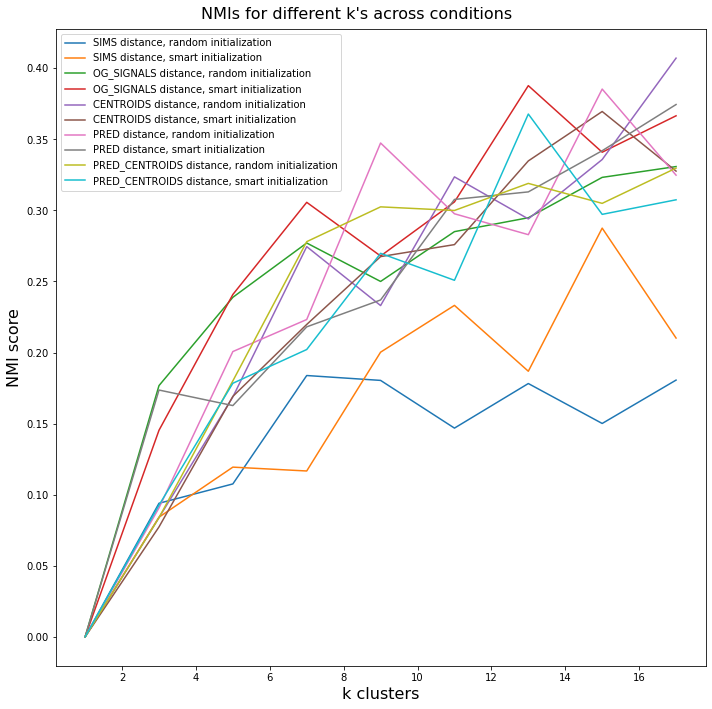

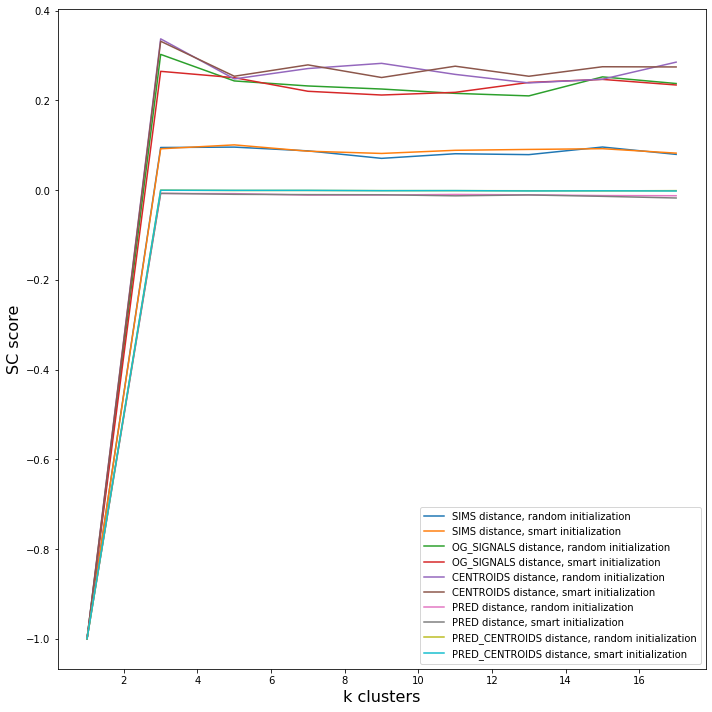

In [22]:
plot_NMIs = Plot()
plot_NMIs.inc(ylabel="NMI score", xlabel="k clusters")
plot_sils = Plot()
plot_sils.inc(ylabel="SC score", xlabel="k clusters")

for name, nmi in nmis.items():
    print(f"{name}, best NMI: {np.max(nmi)} at k={cluster_numbers[np.argmax(nmi)]} clusters")
    plot_NMIs.add(nmi,x=cluster_numbers, label=name)

for name, sil in sils.items():
    print(f"{name}, best SC: {np.max(sil)} at k={cluster_numbers[np.argmax(sil)]} clusters")
    plot_sils.add(sil,x=cluster_numbers, label=name)

plot_NMIs.finalize("NMIs for different k's across conditions")
plot_sils.finalize("NMIs for different k's across conditions")

Plot progress over kmeans iterations with k=7 clusters.

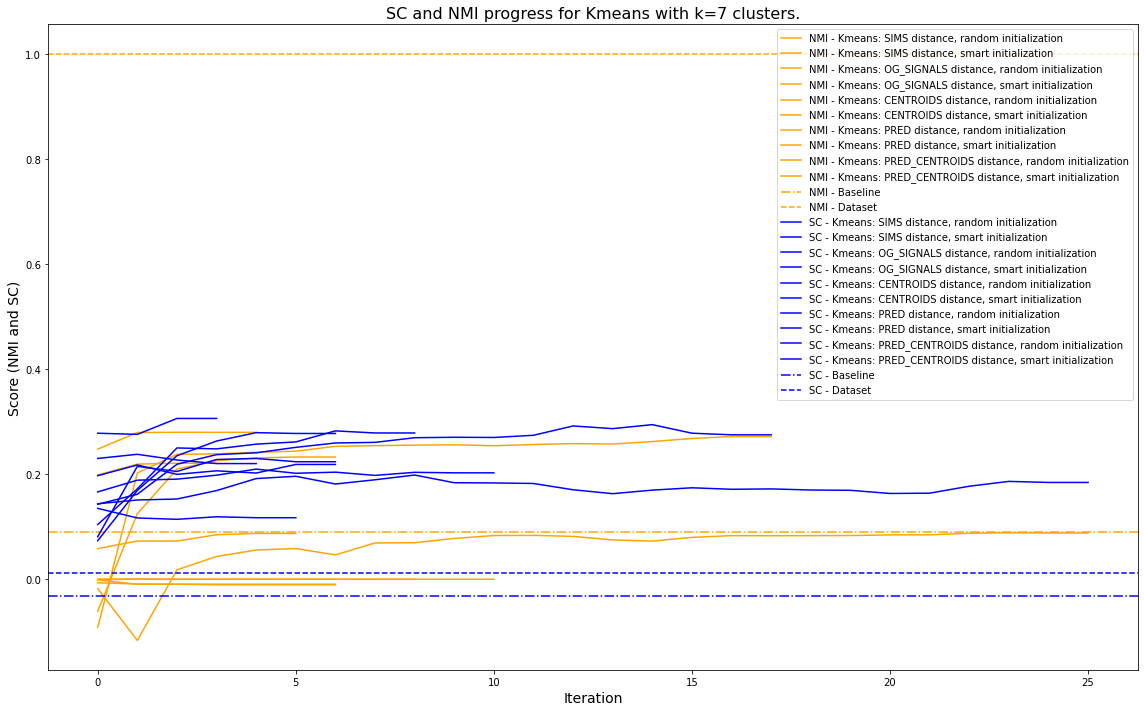

In [57]:
# TODO: SEPARATE PLOTS


def plot_progress2(nmis_example_runs, sils_example_runs, title=''):
    plt.figure(figsize=(16,10))
    for (name, nmi) in nmis_example_runs.items():
        plt.plot(nmi[0], color="orange", label="NMI - Kmeans: "+name)
    plt.axhline(y=nmi_baseline, color='orange', linestyle='dashdot', label="NMI - Baseline")
    plt.axhline(y=nmi_truth, color='orange', linestyle='dashed', label="NMI - Dataset")
    for (name, sil) in sils_example_runs.items():
        plt.plot(sil[0], color="blue", label="SC - Kmeans: "+name)
    plt.axhline(y=sil_baseline, color='blue', linestyle='dashdot', label="SC - Baseline")
    plt.axhline(y=sil_truth, color='blue', linestyle='dashed', label="SC - Dataset")
    plt.legend()
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Score (NMI and SC)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

plot_progress2(nmis_example_runs, sils_example_runs, title="SC and NMI progress for Kmeans with k=7 clusters.")
